## Let's start by download a text dataset. We'll be using the Real or Not? dataset from Kaggle which contains text-based Tweets about natural disasters.

The Real Tweets are actually about disasters.

In [1]:
#ignore all warnings
import warnings
warnings.filterwarnings(action='ignore')

#importing libraries
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline as PP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [2]:
#pip install tensorflow_hub

In [3]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train_df.shape

(7613, 5)

In [6]:
#we are gonna work on training data so lets's get split it to the training and validation set
train_sentences,val_sentences,train_labels,val_labels = train_test_split(train_df['text'].to_numpy(),
                                                                         train_df['target'].to_numpy(),
                                                                         test_size= 0.2, # 20% of data gonna be used for testing
                                                                         random_state= 42)

# Converting text to numbers
There are 2 ways to turn text to numbers
1. Tokenization
* Word-Level Tokenization
* Character Level Tokenization
* Sub-Word Tokenization
2. Embedding
* Use ( sucs as tf.keras.layers.Embedding) to create new Embedding
* Or use pre-learned Embedding

In [7]:
#let's create text vectorizer
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=None,
                                                    standardize='lower_and_strip_punctuation',
                                                    split='whitespace',
                                                    ngrams=None,
                                                    output_mode='int',
                                                    output_sequence_length=None,
                                                    pad_to_max_tokens=False)

In [8]:
#fit the text vectorizer to the train sentences
text_vectorizer.adapt(train_sentences)

In [9]:
sample_sentence = train_sentences[0]
sample_sentence, text_vectorizer([sample_sentence])

('Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused surrender. https://t.co/VhmtyTptGR',
 <tf.Tensor: shape=(1, 18), dtype=int64, numpy=
 array([[17198,     8,  4962,  2917,     6,   156,     5,   438,   216,
           118,     4,  2377,  4973,  1177,   240,  4381,  4119, 14803]],
       dtype=int64)>)

# It is time to build a model and specifically, we'll be building the following:

- Model 0: Naive Bayes (baseline)
- Model 1: Feed-forward neural network (dense model)
- Model 2: LSTM model
- Model 3: GRU model
- Model 4: Bidirectional-LSTM model
- Model 5: 1D Convolutional Neural Network
- Model 6: TensorFlow Hub Pretrained Feature Extractor
- Model 7: Same as model 6 with 10% of training data

# Model 0: Baseline Model

In [10]:
#create the model
model_0 = PP(steps=[
    ('tdf', TfidfVectorizer()), #convert text to numbers using tfidfvectorizer
    ('clf', MultinomialNB())    #model the text
])

#fit the model
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tdf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [11]:
#let's look at the score
model_0_score = model_0.score(val_sentences,val_labels)
print(f'The Accuracy Score of Baseline model is {round(model_0_score * 100,2)}%')

The Accuracy Score of Baseline model is 79.97%


In [12]:
model_0_predictions = model_0.predict(val_sentences)

In [13]:
#let's create function to see our model all results (accuracy, presicion,f1, recall)
def calculate_metrics(y_true, y_pred):
    model_results = { 
        'accuracy': round(accuracy_score(y_true,y_pred),2),
        'recall': round(recall_score(y_true,y_pred),2),
        'precision': round(precision_score(y_true,y_pred),2),
        'f1_score': round(f1_score(y_true,y_pred)*100,2),
    }
    return model_results

In [14]:
calculate_metrics(val_labels, model_0_predictions)

{'accuracy': 0.8, 'recall': 0.63, 'precision': 0.86, 'f1_score': 72.84}

# Model 1: Simple Dense Model

In [15]:
#create the model
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding,
                           input_shape = [],
                           dtype = tf.string,
                           trainable = True)

model_1 = tf.keras.models.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
])


#compile the model
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
               optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
               metrics = ['accuracy'])

#fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              batch_size = 512,
                              epochs= 10,
                              validation_data=(val_sentences,val_labels))


Epoch 1/10
12/12 [==============================] - 9s 749ms/step - loss: 0.5697 - accuracy: 0.7197 - val_loss: 0.4690 - val_accuracy: 0.7905
Epoch 2/10
12/12 [==============================] - 8s 646ms/step - loss: 0.2842 - accuracy: 0.8885 - val_loss: 0.5170 - val_accuracy: 0.7846
Epoch 3/10
12/12 [==============================] - 8s 647ms/step - loss: 0.1172 - accuracy: 0.9603 - val_loss: 0.6798 - val_accuracy: 0.7649
Epoch 4/10
12/12 [==============================] - 7s 622ms/step - loss: 0.0519 - accuracy: 0.9826 - val_loss: 0.8582 - val_accuracy: 0.7557
Epoch 5/10
12/12 [==============================] - 8s 662ms/step - loss: 0.0301 - accuracy: 0.9900 - val_loss: 0.9815 - val_accuracy: 0.7564
Epoch 6/10
12/12 [==============================] - 9s 757ms/step - loss: 0.0228 - accuracy: 0.9915 - val_loss: 1.0336 - val_accuracy: 0.7564
Epoch 7/10
12/12 [==============================] - 9s 756ms/step - loss: 0.0210 - accuracy: 0.9939 - val_loss: 1.0796 - val_accuracy: 0.7577
Epoch 

<Figure size 1600x900 with 0 Axes>

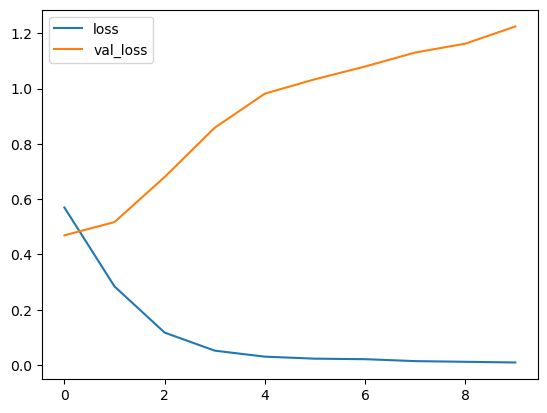

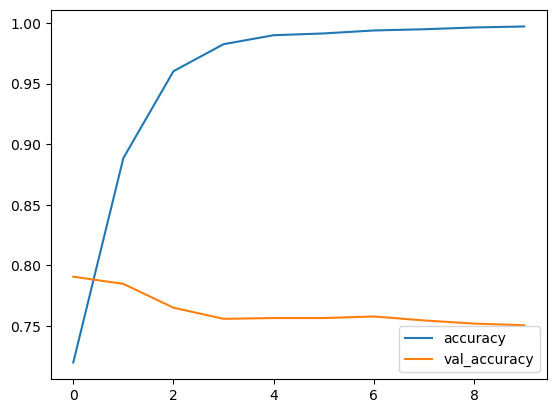

In [16]:
plt.figure(figsize=(16,9))
pd.DataFrame(model_1_history.history)[['loss','val_loss']].plot()
pd.DataFrame(model_1_history.history)[['accuracy','val_accuracy']].plot()
plt.show()

In [17]:
val_sentences,val_labels

(array(['So you have a new weapon that can cause un-imaginable destruction.',
        'The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@',
        'DT @georgegalloway: RT @Galloway4Mayor: \x89ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q',
        ...,
        'Man charged over fatal crash near Dubbo refused bail http://t.co/HDBMfOVUtZ via @dailyliberal',
        '#usNWSgov Severe Weather Statement issued August 05 at 10:38PM EDT by NWS: ...THE SEVERE THUNDERSTORM WARNING ... http://t.co/7HuEN4rWrn',
        "Great British &lt;b&gt;Bake&lt;/b&gt; Off's back and Dorret's &lt;b&gt;chocolate&lt;/b&gt; gateau collapsed - JAN\x89Û_ http://t.co/53LORsrGqf"],
       dtype=object),
 array([1, 0, 1, ..., 1, 1, 0], dtype=int64))

In [18]:
predictions_1 = model_1.predict(val_sentences)

48/48 [==============================] - 3s 63ms/step


In [19]:
#let's see results(is there overfitting?)
df_1 = pd.DataFrame(list(zip(val_labels[:20],predictions_1[:20])),columns=['Real Labels','Predictions'])
df_1['Predictions'] = df_1['Predictions'].apply(lambda x:round(x[0]))
df_1['Validation_Sentences'] = val_sentences[:20]
df_1

,Real Labels,Predictions,Validation_Sentences
0,1,0,So you have a new weapon that can cause un-ima...
1,0,0,The f$&amp;@ing things I do for #GISHWHES Just...
2,1,0,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...
3,0,0,Aftershock back to school kick off was great. ...
4,0,0,in response to trauma Children of Addicts deve...
5,0,0,@Calum5SOS you look like you got caught in a r...
6,1,0,my favorite lady came to our volunteer meeting...
7,1,0,@brianroemmele UX fail of EMV - people want to...
8,0,1,Can't find my ariana grande shirt this is a f...
9,1,1,The Murderous Story Of AmericaÛªs First Hijac...


In [20]:
val_sentences[8]

"Can't find my ariana grande shirt  this is a fucking tragedy"

## Model 2: LSTM Model

In [21]:
#let's change train sentence to the numbers
vectorized_train_sentences = text_vectorizer(train_sentences)
vectorized_val_sentences = text_vectorizer(val_sentences)

# Create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)

# Convert text sentences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

# Pad sequences to a fixed length (e.g., max_len)
max_len = 100
vectorized_train_sentences = pad_sequences(train_sequences, maxlen=max_len)
vectorized_val_sentences = pad_sequences(val_sequences, maxlen=max_len)

In [32]:
max_len = 100
vocab_size = len(tokenizer.word_index) + 1

#create lstm model
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=64,input_length=max_len),
    tf.keras.layers.LSTM(8,return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(16,return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(8,return_sequences=True),
    tf.keras.layers.Dense(1,activation= 'sigmoid')
])

#compile the model
model_2.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                metrics = 'accuracy')

#fit the model
model_2_history = model_2.fit(x = vectorized_train_sentences,
                              y = train_labels.reshape(-1,1),
                              validation_data=(vectorized_val_sentences,val_labels.reshape(-1,1)),
                              epochs =10
                             )

Epoch 1/10
191/191 [==============================] - 14s 57ms/step - loss: 0.6827 - accuracy: 0.5731 - val_loss: 0.6790 - val_accuracy: 0.5885
Epoch 2/10
191/191 [==============================] - 10s 53ms/step - loss: 0.6618 - accuracy: 0.6028 - val_loss: 0.6590 - val_accuracy: 0.6037
Epoch 3/10
191/191 [==============================] - 12s 62ms/step - loss: 0.6378 - accuracy: 0.6136 - val_loss: 0.6572 - val_accuracy: 0.6055
Epoch 4/10
191/191 [==============================] - 12s 64ms/step - loss: 0.6186 - accuracy: 0.6259 - val_loss: 0.6635 - val_accuracy: 0.6050
Epoch 5/10
191/191 [==============================] - 15s 78ms/step - loss: 0.6079 - accuracy: 0.6308 - val_loss: 0.6760 - val_accuracy: 0.6038
Epoch 6/10
191/191 [==============================] - 13s 66ms/step - loss: 0.6004 - accuracy: 0.6334 - val_loss: 0.6844 - val_accuracy: 0.6029
Epoch 7/10
191/191 [==============================] - 12s 63ms/step - loss: 0.5949 - accuracy: 0.6361 - val_loss: 0.6909 - val_accuracy:

In [33]:
def view_plots(history):
    plt.figure(figsize=(16,9))
    pd.DataFrame(history.history)[['loss','accuracy']].plot()
    pd.DataFrame(history.history)[['val_loss','val_accuracy']].plot()
    plt.show()

<Figure size 1600x900 with 0 Axes>

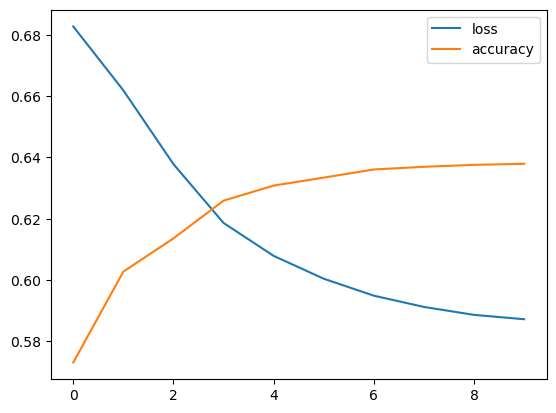

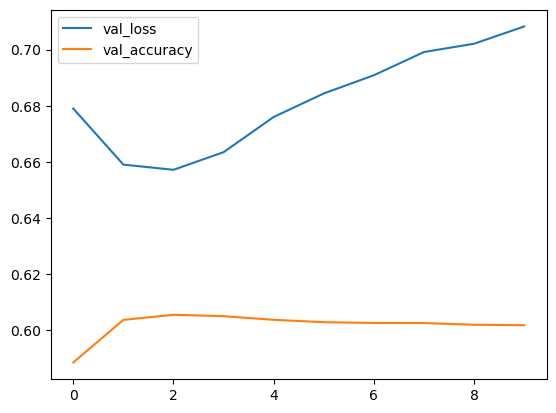

In [34]:
view_plots(model_2_history)

In [35]:
def results(model):  
    probabilities = model.predict(vectorized_val_sentences)
    df = pd.DataFrame(list(zip(val_labels[:20],probabilities[:20])),columns=['Real Labels','Predictions'])
    df['Predictions'] = df_1['Predictions'].apply(lambda x:round(x[0]))
    df['Validation_Sentences'] = val_sentences[:20]
    return df

In [36]:
probabilities = model_2.predict(vectorized_val_sentences)


48/48 [==============================] - 1s 9ms/step
